In [1]:
# !pip install optuna
# !pip install jupyterlab-optuna
# !pip install optuna-fast-fanova gunicorn
# !pip install imbalanced-learn
# !pip install hyperopt
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install optuna-integration
#!pip install ipywidgets
#!pip install imblearn
#!pip install networkx
#!pip install cloudpickle
#!pip install plotly sqlalchemy imageio PyWavelets tifffile

In [2]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import Scikit-learn modules  
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, log_loss, roc_auc_score, confusion_matrix, recall_score, average_precision_score

# Import display modules
from IPython.display import Markdown, display
from ipywidgets import widgets, Layout
from IPython import display as disp
from IPython.display import display, HTML

# Sampling
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter

# Define a function for printing using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#Bold text delimiters
start_bold = "\033[1m"
end_bold = "\033[0;0m"

# Import models
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb

# Import optimizers
import optuna
from optuna_integration import CatBoostPruningCallback
import warnings
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

In [3]:
#load the dataset and preview the first rows
df = pd.read_csv("./Data/diabetes.csv", sep = ",")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

In [4]:
#Verify that all columns have numeric types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
#Check the target variable label values
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
#Get the summary sttistics for all the columns
display(round(df.describe(), 3))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


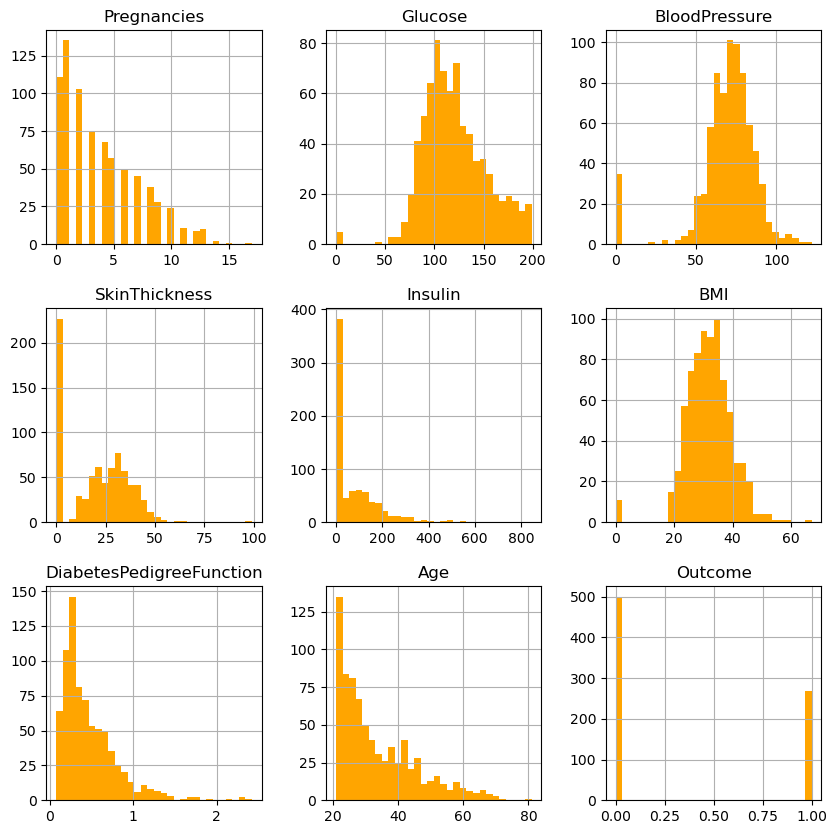

In [7]:
df.hist(bins = 30, figsize = (10, 10), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young participants.
* Zero values for skin thickness, glucose, insulin, blood presure, and bmi indicate missing measurements. 
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) resulting in imbalanced target classes.     

# Define helper functions

The following lines of code will be reused throughout the project and thus have been packed in a set of functions for easy access. 

In [8]:
# Define a function to extract information about missing measurements 
def print_missing_data_summary(x):
    '''
    This function will scan for missing values for different features and feature combinations at different steps of the imputation process.

    Symbol dicionary:
    
    N_GLU - Number of missing Glucose measurements 
    N_INS - Number of missing Insulin measurements
    N_BMI - Number of missing BMI measurements
    N_BPS - Number of missing Blood Pressure measurements
    N_STH - Number of missing Skin Thickness measurements     
    '''
    def printmd(string, color=None):
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))  
    
    display(Markdown('---'))
    printmd(f"**N_GLU**: {x['Glucose'].isna().sum()}", color="#9DC183")
    printmd(f"**N_INS**: {x['Insulin'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BMI**: {x['BMI'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BPS**: {x['BloodPressure'].isna().sum()}", color="#9DC183")
    printmd(f"**N_STH**: {x['SkinThickness'].isna().sum()}", color="#9DC183")
    display(Markdown('---'))    

def render_widgets(num_widgets, titles, objects):
    # Create output widgets
    widgets_list = [widgets.Output() for _ in range(num_widgets)]
    
    # Render content in output widgets
    for i in range(num_widgets):
        with widgets_list[i]:
            # Display title in bold format
            title_html = "<b>{}</b>".format(titles[i])
            disp.display(disp.HTML(title_html))
            disp.display(objects[i])
    
    # Add CSS styles to distribute free space
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        justify_content='flex-start',
                        width='auto'
                       )
    
    # Create Horizontal Box container
    hbox = widgets.HBox(widgets_list, layout=box_layout)
    
    # Render hbox
    disp.display(hbox)

from IPython.display import display, HTML

def render_static_widgets(num_widgets, titles, objects):
    # Create a string to hold the HTML content
    html_content = "<div style='display: flex;'>"
    
    # Add content for each widget
    for i in range(num_widgets):
        # Create a div for each widget
        html_content += "<div style='margin-right: 20px;'>"
        
        # Display title in bold format
        title_html = "<b>{}</b><br>".format(titles[i])
        html_content += title_html
        
        # Add object content
        html_content += objects[i]._repr_html_()
        
        # Close the div
        html_content += "</div>"
    
    # Close the flex container
    html_content += "</div>"
    
    # Create HTML widget with the combined content
    html_widget = HTML(html_content)
    
    # Display the HTML widget
    display(html_widget)

#Define a function to summarize the classification metrics
def print_classification_metrics(model, x_test, y_test, cm = True, return_metrics=False):
    
    # performance of the trained model using the testing set
    test_result = model.score(x_test, y_test)

    # make predictions on the test data
    y_predict = model.predict(x_test)

    # predict class probabilities on the test set
    y_predict_proba = model.predict_proba(x_test)
   
    # Calculate log loss for the test set
    log_loss_value = round(log_loss(y_test, y_predict_proba), 4)

    # Calculate ROC AUC for the test set    
    roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])

    # Define recall levels for interpolation
    recall_levels = np.linspace(0, 1, 100)
        
    # Calculate Precision-Recall score for the TEST set
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_predict_proba[:, 1])

    # Interpolate precision values for each recall level
    interp_precision_test = np.interp(recall_levels, recall_test[::-1], precision_test[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_test = np.trapz(interp_precision_test, recall_levels)
    
    #display test performance metrics
    test_report = pd.DataFrame(classification_report(y_test,
                                                     y_predict,
                                                     digits=4,
                                                     output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)    
    
    add_test_metrics = pd.DataFrame([{'Log Loss': np.round(log_loss_value, 2),
                                     'ROC AUC': np.round(roc_auc, 2),
                                     'AUPRC': np.round(auprc_test, 2)}], columns = ['Log Loss',
                                                                                 'ROC AUC',
                                                                                 'AUPRC']).transpose().rename(columns = {0: 'Score'})
    if return_metrics == False:
        titles = ['Performance report', 'Additional metrics']
        render_static_widgets(2, titles, [test_report, add_test_metrics]) 
    
    elif return_metrics == True:

        # Create a dictionary to store the metrics
        metrics_dict = {
            "test_report": test_report,
            "add_test_metrics": add_test_metrics
        } 

        return metrics_dict  

    if cm == True:
        # Print the confusion matrix
        cm = confusion_matrix(y_test, y_predict)
            
        # Set the labels for the confusion matrix
        class_labels = ['Negative', 'Positive']  # Replace with your actual class labels
        
        # Create a heatmap with labels
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy', xticklabels=class_labels, yticklabels=class_labels)
        
        # Add labels and title
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        
        # Adjust the spacing between subplots
        plt.subplots_adjust(left=0.2, bottom=0.2)
        
        # Show the plot
        plt.show()

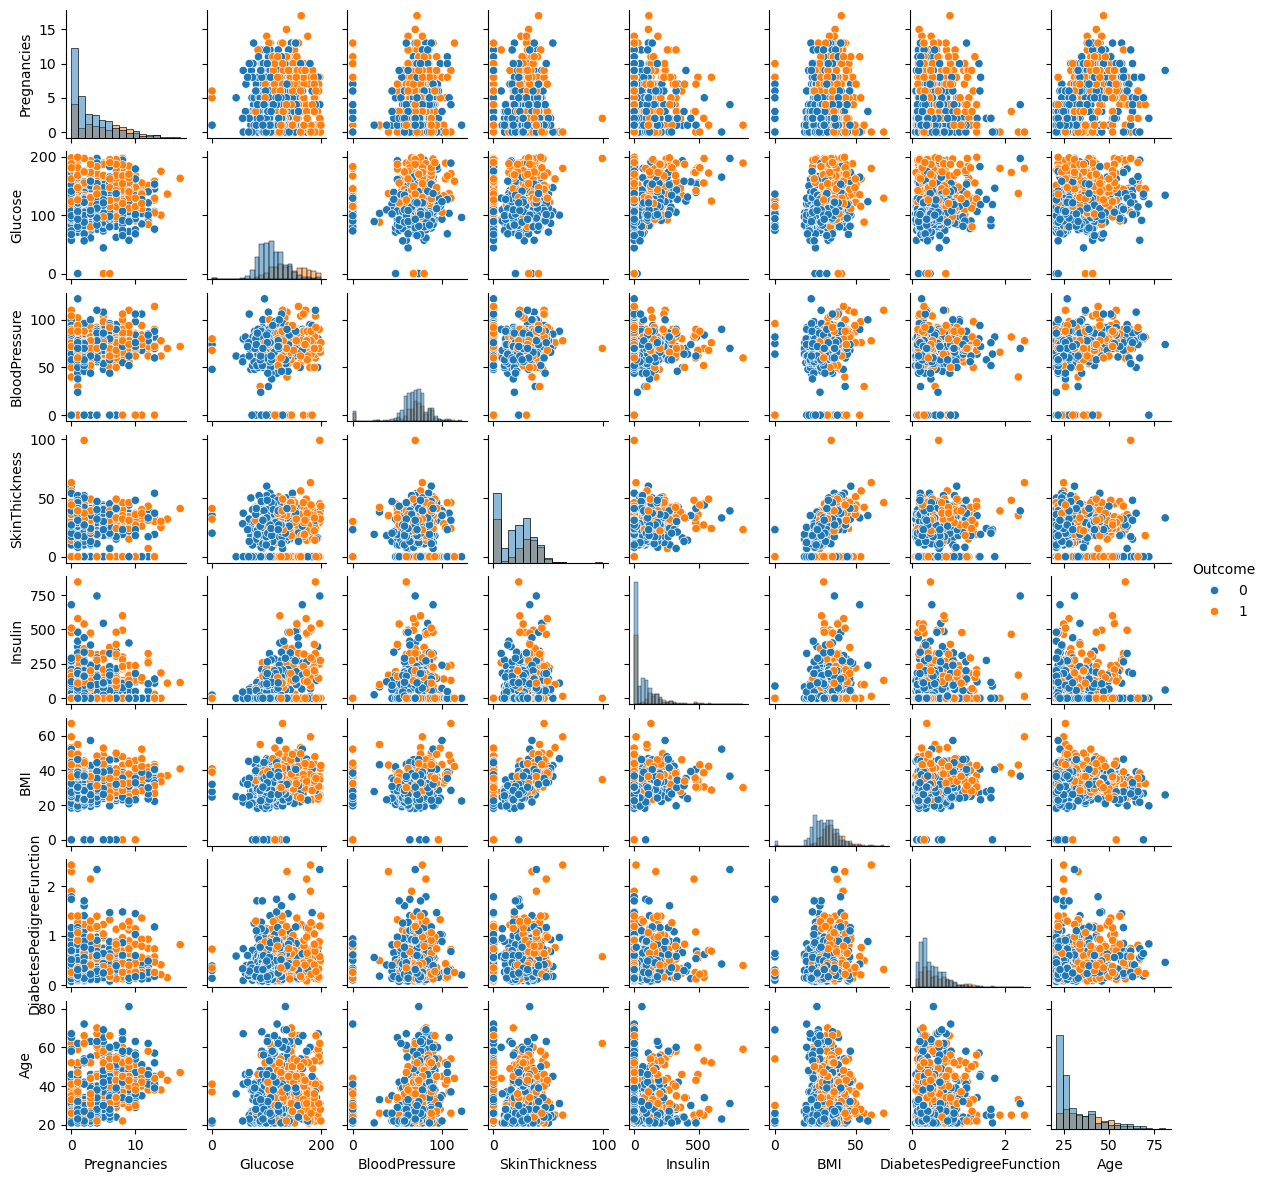

In [9]:
#display a pairplot to visualize correlations between feature pairs and feature distributions 
sns.pairplot(df, hue = 'Outcome', 
             height = 1.5, 
             #corner = True, 
             kind = 'scatter', 
             diag_kind = 'hist')

In [10]:
cols = ["Glucose","Insulin","BMI","BloodPressure","SkinThickness"]
df[cols] = df[cols].replace({0: np.nan})

print_missing_data_summary(df)

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 11</span>

<span style='color:#9DC183'>**N_BPS**: 35</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [11]:
# split the dataframe into target and features

y = df["Outcome"].copy() # target

# Create a completely independent copy of the features
X = df.loc[:, df.columns != "Outcome"].copy()

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [12]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = False)

cols = ["Glucose", "BMI", "BloodPressure"]
X[cols] = imp_mean.fit_transform(X[cols])

print_missing_data_summary(X)

---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

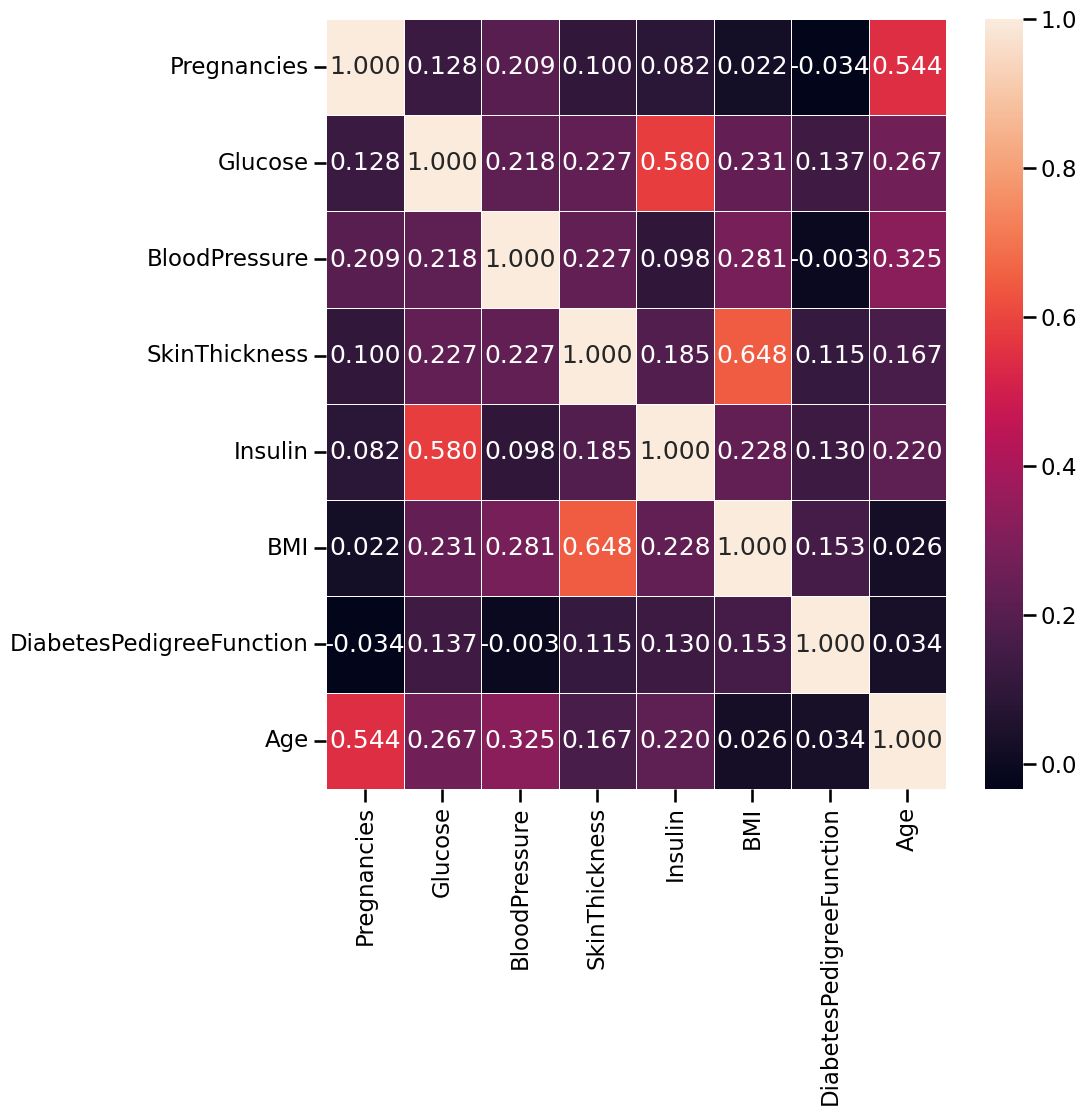

In [13]:
# Create a correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (10, 10))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

# Using model-based imputation for the missing values

In [14]:
# Define the columns to use for linear regression
cols = ["Glucose", "Insulin", "BMI", "Age"]

# Create training and testing sets using the non-missing samples
y_train_imp = X[cols[1]].dropna()

# Include both "Glucose" and "BMI" columns for the training set
X_train_imp = X.loc[y_train_imp.index, [cols[0], 
                                        cols[2],
                                       cols[3]]].values

# Define the hyperparameter search space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)), 
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 64, 1)),    
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1.0)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 100, 1)), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    
}

# Define the objective function 
def lightgbm_objective(params):
    regressor = lgb.LGBMRegressor(        
        objective = 'regression',
        max_depth = params['max_depth'],
        n_estimators = params['n_estimators'],
        learning_rate = params['learning_rate'],
        num_leaves = params['num_leaves'],        
        reg_lambda = params['reg_lambda'],
        colsample_bytree = params['colsample_bytree'],
        min_child_samples = params['min_child_samples'],
        subsample = params['subsample'],
        seed = 21,
        verbosity = -1,
    )

    score = cross_val_score(regressor, 
                            X_train_imp,
                            y_train_imp, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error'
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=lightgbm_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a LightGBM Regressor with the best hyperparameters
gb_imputer = lgb.LGBMRegressor(objective = "regression",
                               **best_params, 
                               random_state=21, 
                               verbosity = -1)

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
#X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)


X_new = X.loc[y_missing_idx, [cols[0],
                              cols[2],
                             cols[3]]].values

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|████████| 100/100 [00:16<00:00,  5.89trial/s, best loss: 96.22471334578577]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [15]:
# Define the columns to use for linear regression
cols = ["BMI", "SkinThickness"]

# Create training and testing sets using the non-missing samples
y_train_imp = X[cols[1]].dropna()
X_train_imp = X.loc[y_train_imp.index, cols[0]].values.reshape(-1, 1)

# Define the hyperparameter search space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)), 
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 64, 1)),    
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1.0)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 100, 1)), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    
}

# Define the objective function 
def lightgbm_objective(params):
    regressor = lgb.LGBMRegressor(        
        objective = 'regression',
        max_depth = params['max_depth'],
        n_estimators = params['n_estimators'],
        learning_rate = params['learning_rate'],
        num_leaves = params['num_leaves'],        
        reg_lambda = params['reg_lambda'],
        colsample_bytree = params['colsample_bytree'],
        min_child_samples = params['min_child_samples'],
        subsample = params['subsample'],
        seed = 21,
        verbosity = -1,
    )

    score = cross_val_score(regressor, 
                            X_train_imp,
                            y_train_imp, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error'
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=lightgbm_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a LightGBM Regressor with the best hyperparameters
gb_imputer = lgb.LGBMRegressor(objective = "regression",
                               **best_params, 
                               random_state=21, 
                               verbosity = -1)

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|█████████| 100/100 [00:21<00:00,  4.58trial/s, best loss: 7.90073810033604]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 0</span>

---

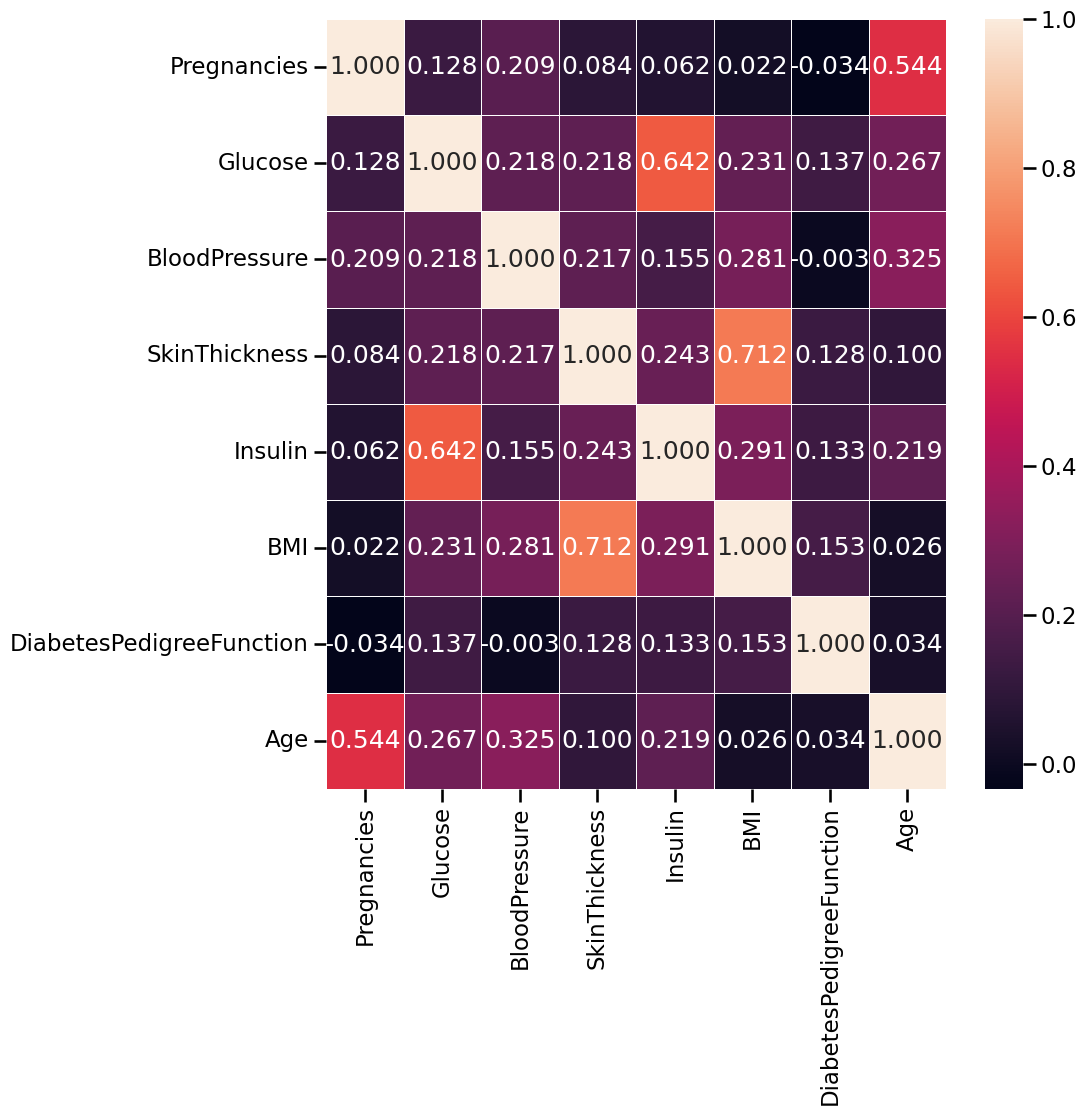

In [16]:
# Create a correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (10, 10))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

In [17]:
df1 = pd.DataFrame(pd.read_csv("./Data/diabetes.csv", sep = ",").dtypes)
df2 = pd.DataFrame(X.dtypes)

titles = ['Original dtypes', 'New dtypes' ]
render_static_widgets(2, titles, [df1, df2])

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64
,0


In [18]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

# Restore the original datatypes
X[cols] = X[cols].astype(int)

# Verify that the data types have been restored
display(pd.DataFrame(X.dtypes))

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64


In [19]:
# Count the number of samples in each target class
counter = Counter(y)

print(counter)

Counter({0: 500, 1: 268})


In [20]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.866


In [21]:
# split the labels and features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(514, 8)
(514,)

Testing set
(254, 8)
(254,)



In [22]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

RangeIndex(start=0, stop=768, step=1)

Index([341, 695, 387, 528, 619, 195, 700, 581, 579, 131,
       ...
       570, 107, 588,   2, 355,  96, 544, 508, 470, 727],
      dtype='int64', length=514)


In [23]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [24]:
# from sklearn.preprocessing import MinMaxScaler

# # Create a StandardScaler object
# scaler = MinMaxScaler()

# # Fit and transform the training data
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# # Transform the test data (using the same scaling parameters as the training data)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# display(pd.DataFrame(X_train_scaled).head())

# print()

# display(X_train.head())

# Train a baseline XGBoost Classifier

In [25]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',
                               scale_pos_weight = 1.866,
                               seed = 21,
                               ).fit(X_train, y_train)

# Train a baseline model on the "raw" data

In [26]:
# Reload the unprocessed dataset
df_raw = pd.read_csv("./Data/diabetes.csv", sep = ",")

# split the unprocessed data into target and features

y_raw = df_raw["Outcome"] # target
X_raw = df_raw.drop(columns = ["Outcome"]) # features

# split the data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.33, random_state = 21, stratify = y_raw)

#Build a classifier with minimum parameters
xgb_classifier_raw = XGBClassifier(objective = 'binary:logistic', 
                                   eval_metric = 'logloss', 
                                   scale_pos_weight = 1.866,
                                   seed = 21,
                                   ).fit(X_train_raw, y_train_raw)

## Compare 

In [27]:
# Calculate the 
metrics_raw = print_classification_metrics(xgb_classifier_raw, X_test_raw, y_test_raw, return_metrics=True)

test_report_raw = metrics_raw['test_report']
add_metrics_raw = metrics_raw['add_test_metrics']

metrics_processed = print_classification_metrics(xgb_classifier, X_test, y_test, return_metrics=True)

test_report_processed = metrics_processed['test_report']
add_metrics_processed = metrics_processed['add_test_metrics']

titles = ['Raw report', 'Raw metrics', 'Processed report', 'Processed metrics']
render_static_widgets(4, titles, [test_report_raw, add_metrics_raw, test_report_processed, add_metrics_processed]) 

# Oversampling the minority class using ADASYN

In [28]:
# Build the sample synthesizer
ads = ADASYN(sampling_strategy = 'minority',
           random_state = 21,
           n_neighbors = 8,
           )
# Resample the training data
X_res, y_res = ads.fit_resample(X_train, y_train)

# Verify that the classes are balanced
print()
print('Original dataset shape %s' % Counter(y_train))
print()
print('Resampled dataset shape %s' % Counter(y_res))
print()


Original dataset shape Counter({0: 335, 1: 179})

Resampled dataset shape Counter({0: 335, 1: 330})



In [29]:
# Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',
                               seed = 21,
                               ).fit(X_res, y_res)

# Predict the performance scores of the trained model using the testing set
print_classification_metrics(xgb_classifier, X_test, y_test, cm = False)

# Feature selection

In [30]:
# Select fetures based on k highest scores
selected_features = SelectKBest(chi2, k = 7).fit(X_res, y_res)

# Print the scores and column names
print()
print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_res.columns)


Score List:  [  43.88652421  846.32238042   23.31885194  117.03669302 3140.10552905
   85.15486558   10.87602058  107.79971709]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [31]:
# Select only the highest scoring features from both training and test sets
X_train_best = pd.DataFrame(selected_features.transform(X_res))

X_test_best = pd.DataFrame(selected_features.transform(X_test))

# Compare the selected features with the original set
display(X_train_best.head())
display(X_train.head())

,0,1,2,3,4,5,6
0,1.0,95.0,74.0,21.0,73.0,25.9,36.0
1,7.0,142.0,90.0,24.0,480.0,30.4,43.0
2,8.0,105.0,100.0,36.0,167.0,43.3,45.0
3,0.0,117.0,66.0,31.0,188.0,30.8,22.0
4,0.0,119.0,72.0,26.0,99.0,32.4,24.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
341,1,95,74,21,73,25.9,0.673,36
695,7,142,90,24,480,30.4,0.128,43
387,8,105,100,36,167,43.3,0.239,45
528,0,117,66,31,188,30.8,0.493,22
619,0,119,72,26,99,32.4,0.141,24


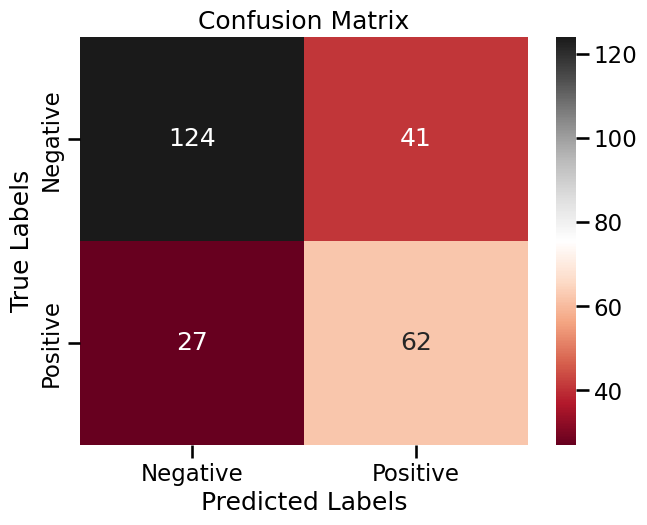

In [32]:
# Restore the original column names
X_train_best = X_train_best.rename(columns = {0: 'Pregnancies', 
                                              1: 'Glucose',
                                              2: 'BloodPressure',
                                              3: 'SkinThickness', 
                                              4: 'Insulin',
                                              5: 'BMI',
                                              6: 'Age',
                                             })
X_test_best = X_test_best.rename(columns = {0: 'Pregnancies',
                                            1: 'Glucose',
                                            2: 'BloodPressure',
                                            3: 'SkinThickness',
                                            4: 'Insulin',
                                            5: 'BMI',
                                            6: 'Age',
                                             })

#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',
                               seed = 21,
                               )

#Fit the classifier to the raw data
xgb_classifier.fit(X_train_best, y_res)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_test_best, y_test)

# Optimizing the XGBoost classifier with optuna 

In [33]:
#Define the target parameters to be optimized
def objective(trial):    
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log = True)
    max_leaves = trial.suggest_int('max_leaves', 2, 64)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)    
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step = 0.05)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.75, 1.95)     
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 1.0, log=True)       

    # Buiuld the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth = max_depth,
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_leaves = max_leaves,
        min_child_weight=min_child_weight,        
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        scale_pos_weight = scale_pos_weight,        
        reg_lambda = reg_lambda,        
        objective = 'binary:logistic',        
        grow_policy = 'lossguide', 
        eval_metric = 'aucpr',
        use_label_encoder = False,
        seed = 21,               
    )

    # Optimize with cross-validation
    scores = cross_val_score(classifier, 
                             X_train_best, y_res,
                             cv=5,
                             scoring='neg_log_loss',
                             verbose = False,
                             )
    # Return the mean of the cross-validation scores
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)

study.optimize(objective, 
               n_trials=100,              
               show_progress_bar = True)

# Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', pd.DataFrame([best_params]).transpose())
print()
print('Best score (Minimum loss): ', study.best_value)
print()

[I 2024-06-03 15:00:08,925] A new study created in memory with name: no-name-d76aafe8-22c5-493b-a272-0d37f757383e


  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
max_depth           6.000000
n_estimators      654.000000
learning_rate       0.005192
max_leaves         39.000000
min_child_weight    1.000000
subsample           0.950000
colsample_bytree    0.814367
scale_pos_weight    1.893669
reg_lambda          0.003953

Best score (Minimum loss):  0.501200128776001



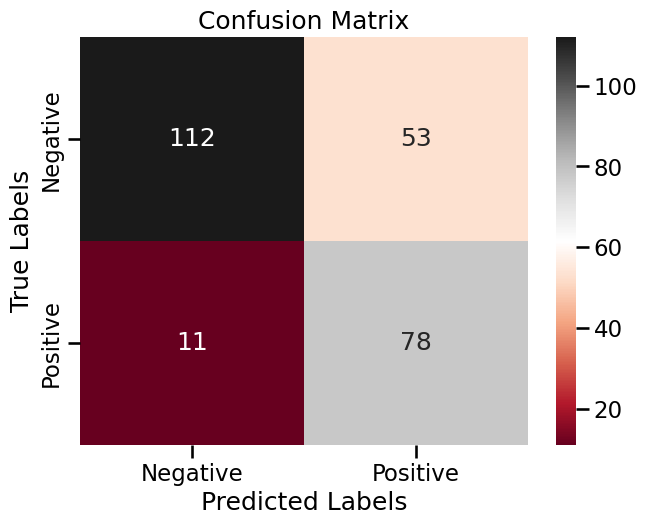

In [34]:
#Train an XGBoost classifier using the optimized parameters
xgb_classifier_opt = XGBClassifier(objective = 'binary:logistic',
                                   **best_params,                                   
                                   grow_policy = 'lossguide',
                                   use_label_encoder = False,
                                   seed = 21,
                                   ).fit(X_train_best, y_res, verbose = 0)

# Test the model and display the performance metrics
print_classification_metrics(xgb_classifier_opt, X_test_best, y_test)

# Optimize an XGBoost classifier using hyperopt

In [35]:
# Define the hyperparameter search space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1.5, 10.5, 1)), 
    'n_estimators': scope.int(hp.quniform('n_estimators', 99.5, 1000.5, 1)), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'max_leaves': scope.int(hp.quniform('max_leaves', 1.5, 64.5, 1)),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.05),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0.5, 10.5, 1)),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),    
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1.0)),
}

# Define the objective function to optimize
def objective(params):
    classifier = XGBClassifier(
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        scale_pos_weight = params['scale_pos_weight'],        
        reg_lambda = params['reg_lambda'],
        objective = 'binary:logistic',        
        use_label_encoder = False,
        seed = 21,        
    )

    # Optimize with cross-validation
    score = cross_val_score(classifier, 
                            X_train_best, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                            
                           )
    # Return the mean of the cross-validation scores
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|███████| 100/100 [01:31<00:00,  1.09trial/s, best loss: 0.4940286641175448]

Best hyperparameters:                            0
colsample_bytree    0.591673
learning_rate       0.009797
max_depth          10.000000
max_leaves         21.000000
min_child_weight    1.000000
n_estimators      629.000000
reg_lambda          0.203755
scale_pos_weight    1.787151
subsample           0.900000

Best score (Minimum loss): 0.4940286641175448


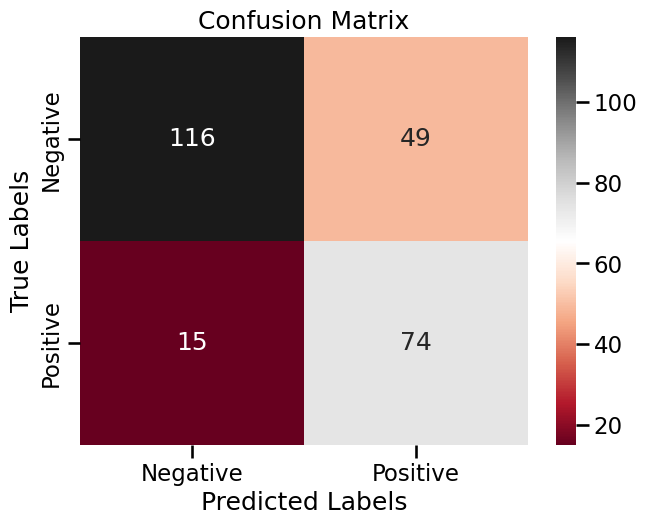

In [36]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

# Train an XGBoost classifier using the optimized parameters
xgb_classifier_hyp = XGBClassifier(objective = 'binary:logistic',                                     
                                   **best_params,                                  
                                   use_label_encoder = False,
                                   seed = 21).fit(X_train_best, y_res, verbose = 0)

# Test the model and display the performance metrics
print_classification_metrics(xgb_classifier_hyp, X_test_best, y_test)

# Optimize a LightGBM model using optuna

In [37]:
# Define the objective function for LightGBM
def lgb_objective(trial):
    params = {        
        'objective': 'binary',        
        'max_depth': trial.suggest_int('max_depth', 2, 10, step = 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64, step = 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step = 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step = 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100, step = 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.75, 1.95),        
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step = 0.05),
        'random_state': 21,         
        'verbosity': -1,
    }

    # Optimize with cross-validation
    scores = cross_val_score(lgb.LGBMClassifier(**params), 
                             X_res, y_res, 
                             cv=5, 
                             scoring='neg_log_loss',                              
                             )
    # Return the mean of the cross-validation scores
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lgb_objective, 
               n_trials=100,               
               show_progress_bar = True)

#Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
max_depth            8.000000
num_leaves          51.000000
n_estimators       908.000000
learning_rate        0.005857
min_child_weight     1.000000
min_child_samples    5.000000
scale_pos_weight     1.915033
reg_lambda           0.705470
colsample_bytree     0.577612
subsample            1.000000

Best score (Minimum loss): 0.46870623732739947



# Train and test a LightGBM model using optimized hyperparameters

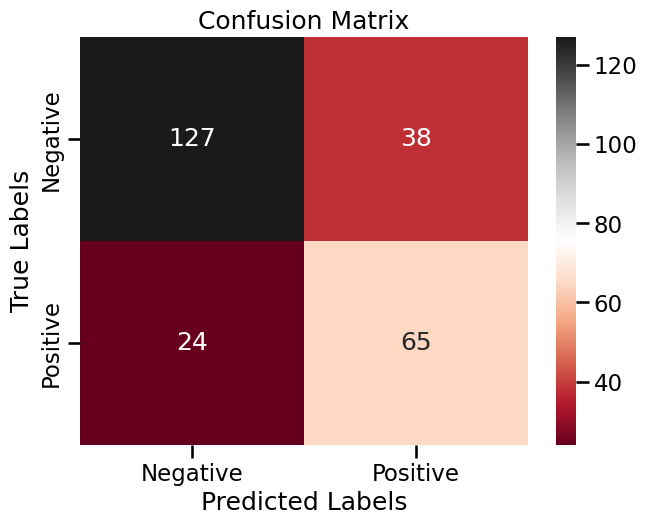

In [38]:
# Train the LightGBM model with the best hyperparameters
lgb_model = lgb.LGBMClassifier(**best_params,
                               verbosity = -1).fit(X_res, y_res)

# Test the model and display the performance metrics
print_classification_metrics(lgb_model, X_test, y_test)

# Optimize a LightGBM classifier using hyperopt

In [39]:
# Define the hyperparameter search space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1.5, 10.5, 1)),    
    'num_leaves': scope.int(hp.quniform("num_leaves", 1.5, 64.5, 1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 100, 5)),    
    'n_estimators': scope.int(hp.quniform('n_estimators', 99.5, 1000.5, 1)),    
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10), # For LightGBM min_child_weight can take continous values    
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.05),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),    
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1.0)),
}

# Define the objective function 
def objective(params):    
    classifier = lgb.LGBMClassifier(        
        objective = 'binary',
        num_leaves = int(params['num_leaves']),
        min_child_samples = int(params['min_child_samples']),
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        scale_pos_weight = params['scale_pos_weight'],        
        reg_lambda = params['reg_lambda'],         
        feature_pre_filter=False,
        seed = 21,        
        verbosity = -1,
    )

    
    # Optimize with cross-validation
    score = cross_val_score(classifier, 
                            X_res, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                             
                           )

    # Return the mean of the cross-validation scores
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|██████| 100/100 [00:34<00:00,  2.94trial/s, best loss: 0.48437766712562313]

Best hyperparameters:                             0
colsample_bytree     0.556166
learning_rate        0.023465
max_depth            8.000000
min_child_samples   15.000000
min_child_weight     2.126729
n_estimators       245.000000
num_leaves          51.000000
reg_lambda           0.060472
scale_pos_weight     1.848084
subsample            0.800000

Best score (Minimum loss): 0.48437766712562313


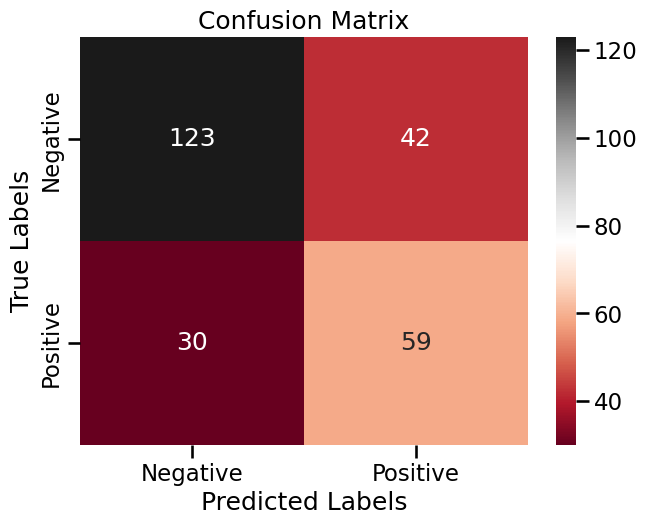

In [40]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

#Train a classifier using the optimized parameters
lgb_classifier_hyp = lgb.LGBMClassifier(objective = 'binary',
                                        **best_params,                                                                             
                                        seed=21,                                        
                                        verbosity = -1).fit(X_res, y_res)

# Test the model and display the performance metrics        
print_classification_metrics(lgb_classifier_hyp, X_test, y_test)

# Optimize a CatBoost classifier using optuna 

In [41]:
# Define the objective function
def catboost_objective(trial):
    params = {
        'objective': 'Logloss',  
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'depth': trial.suggest_int('depth', 2, 10), 
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),        
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100, step = 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.75, 1.95),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step = 1),
        'random_strength': trial.suggest_int('random_strength', 1, 100, step = 1),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0, step = 0.05),
        'random_seed': 21,
        'grow_policy': 'Lossguide',
        'boosting_type': 'Plain',                
        'silent':True,
              
    }

    # Optimize with cross-validation
    scores = cross_val_score(CatBoostClassifier(**params), 
                             X_res, y_res, 
                             cv=5, 
                             scoring='neg_log_loss',                             
                            )
    # Return the mean of the cross-validation scores
    return -scores.mean()

    

# Create an Optuna study
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)

study.optimize(catboost_objective, 
               n_trials=100,                
               show_progress_bar = True)

# Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
colsample_bylevel    0.955449
depth                8.000000
learning_rate        0.013000
num_leaves          49.000000
min_data_in_leaf    59.000000
scale_pos_weight     1.791518
l2_leaf_reg          0.020336
n_estimators       825.000000
random_strength     18.000000
subsample            0.550000

Best score (Minimum loss): 0.48435797213171095



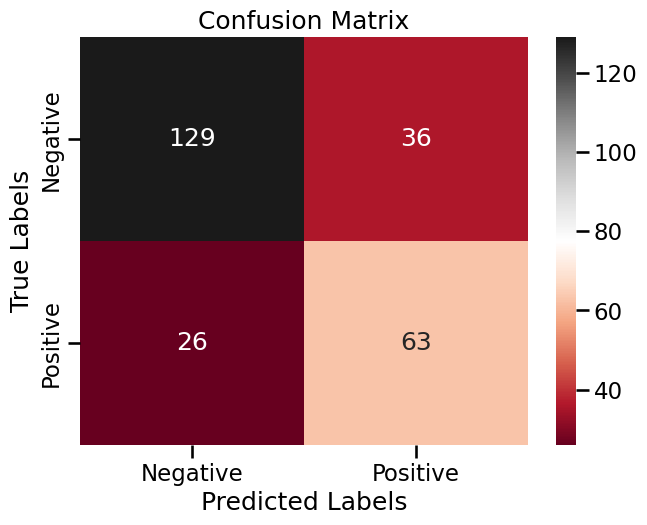

In [39]:
# Train the CatBoost model with the best hyperparameters
catboost_opt = CatBoostClassifier(objective = 'Logloss',
                                    **best_params,                                    
                                    grow_policy = 'Lossguide',
                                    silent = True,
                                    boosting_type = 'Plain',
                                    random_seed = 21,
                                   ).fit(X_res, y_res)

# Test the model and display the performance metrics
print_classification_metrics(catboost_opt, X_test, y_test)

# Optimize a CatBoost classifier using hyperopt

In [40]:
# Define the hyperparameter search space
space = {
    'depth': scope.int(hp.quniform('depth', 1.5, 10.5, 1)), 
    'n_estimators': scope.int(hp.quniform('n_estimators', 99.5, 1000.5, 1)),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'max_leaves': scope.int(hp.quniform('max_leaves', 1.5, 64.5, 1)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(0.001), np.log(1.0)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': scope.int(hp.quniform("min_data_in_leaf", 4.5, 100.5, 1)), 
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.05),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    classifier = CatBoostClassifier(        
        objective = 'Logloss',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        scale_pos_weight = params['scale_pos_weight'],
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_state = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
    )

    # Optimize with cross-validation    
    score = cross_val_score(classifier, 
                            X_res, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                             
                           )
    
    # Return the mean of the cross-validation scores
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|███████| 100/100 [07:42<00:00,  4.63s/trial, best loss: 0.4568810268358184]

Best hyperparameters:                             0
colsample_bylevel    0.654966
depth                6.000000
l2_leaf_reg          0.596793
learning_rate        0.015805
max_leaves          33.000000
min_data_in_leaf    23.000000
n_estimators       760.000000
random_strength     16.000000
scale_pos_weight     1.759128
subsample            0.900000

Best score (Minimum loss): 0.4568810268358184


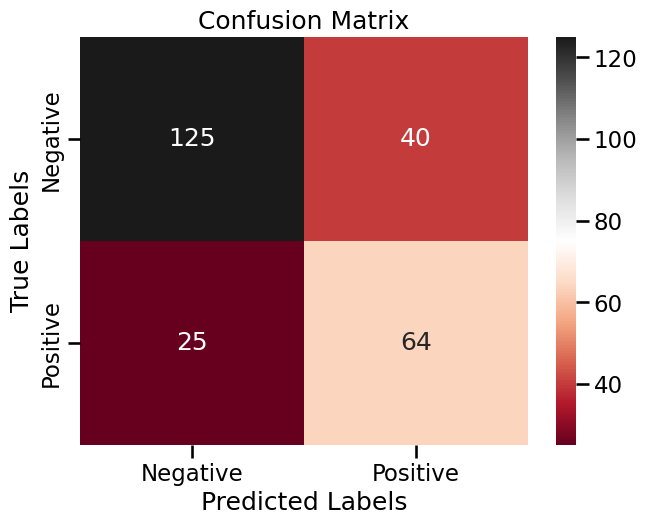

In [41]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

# Create a new CatBoostClassifier instance with the best hyperparameters
catboost_hyp = CatBoostClassifier(
    objective='Logloss',
    **best_params,
    random_state=21,
    grow_policy = 'Lossguide',
    boosting_type = 'Plain',
    silent = True,      
).fit(X_res, y_res)

# Test the model and display the performance metrics
print_classification_metrics(catboost_hyp, X_test, y_test)